# Modelo de predicción de aceptación de tarjeta de crédito

## By: Sergio Quintero

### Objetivo: Desarrollar un modelo que permita predecir si el cliente aceptará una tarjeta de crédito a partir de los datos demográficos, sociales, financieros, y de negocio

#### Arquitectura de la solución

# Modelado

##### A continuación todo el análisis exploratorio de los datos, análisis estadístico, y modelado

## Importación de librerías a utilizar

In [83]:
#manipulacion de datos
import pandas as pd
import numpy as np

#estadística
import pingouin as pg
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

#visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

#preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

#Machine Learning Algorithms (MLA)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import joblib

#metricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#banalceo de datos
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

## Exploración de datos

Lectura de datos. Se leen los datos de entrenamiento para todo el análisis exploratorio

In [10]:
datos = pd.read_csv('../data/insumo/train.csv')

Dimensionamiento de los datos 

In [11]:
datos.shape

(23099, 21)

Identificación de columnas

In [12]:
datos.columns

Index(['ID', 'Edad', 'Tipo_Trabajo', 'Estado_Civil', 'Educacion', 'mora',
       'Vivienda', 'Consumo', 'Contacto', 'Mes', 'Dia', 'Campana',
       'Dias_Ultima_Camp', 'No_Contactos', 'Resultado_Anterior',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed', 'y'],
      dtype='object')

Identificación de datos nulos para limpieza

In [13]:
datos.isnull().sum()

ID                    0
Edad                  0
Tipo_Trabajo          0
Estado_Civil          0
Educacion             0
mora                  0
Vivienda              0
Consumo               0
Contacto              0
Mes                   0
Dia                   0
Campana               0
Dias_Ultima_Camp      0
No_Contactos          0
Resultado_Anterior    0
emp_var_rate          0
cons_price_idx        0
cons_conf_idx         0
euribor3m             0
nr_employed           0
y                     0
dtype: int64

No existen valores nulos en ninguna de las columnas, por lo que no es necesario hacer reemplazos por estimadores a no ser que más adelante se encuentren valores atípicos u outliers que puedan afectar el modelado

Identificación de balanceo de datos

In [14]:
datos['y'].value_counts()

y
0    20509
1     2590
Name: count, dtype: int64

In [82]:
datos['y'].value_counts()/datos.shape[0]

y
0    0.887874
1    0.112126
Name: count, dtype: float64

El set de datos se encuentra desbalanceado, siendo el 88.8% correspondientes a rechazo de la tarjeta y el 11.2% a la aceptación de tarjeta.
Esto llevará a que en la etapa de modelado y entrenamiento se deba aplicar técnicas de balanceo de datos para evitar overfitting

Identificación de valores iguales para agrupamiento

In [15]:
def distinct_values(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(column, df[column].unique())

In [16]:
distinct_values(datos)

Tipo_Trabajo ['servicios' 'administrador negocio' 'empleado' 'pensionado' 'tecnico'
 'vendedor ambulante' 'emprendedor' 'ama de casa' 'Vive de los arriendos'
 'desempleado' 'unknown' 'estudiante']
Estado_Civil ['casado' 'single' 'soltero' 'divorced' 'divorciado' 'unknown']
Educacion ['bachillerato' 'primaria' 'unknown' 'bachillerato incompleto' 'pregrado'
 'preescolar' 'Estudiante Universitario' 'Ninguno']
mora ['unknown' 'no' 'si']
Vivienda ['no' 'si' 'unknown']
Consumo ['no' 'si' 'unknown']
Contacto ['telefono fijo' 'celular']
Mes ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Dia ['mon' 'tue' 'wed' 'thu' 'fri']
Resultado_Anterior ['sin contacto' 'fallido' 'satisfactorio']


Se agrupan valores similares como single con soltero y divorced con divorciado

In [17]:
datos['Estado_Civil'] = ["soltero" if x == 'single' else x for x in datos['Estado_Civil']]
datos['Estado_Civil'] = ["divorciado" if x == 'divorced' else x for x in datos['Estado_Civil']]

Descripción de las variables numéricas

In [18]:
datos.describe()

,ID,Edad,Campana,Dias_Ultima_Camp,No_Contactos,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,23099.000000,23099.000000,23099.000000,23099.000000,23099.000000,23099.000000,23099.000000,23099.000000,23099.000000,23099.000000,23099.000000
mean,16420.136499,40.067665,2.560154,962.976060,0.171003,0.095649,85576.471847,-40.485237,3190.939789,5167.329439,0.112126
std,9521.074915,10.449983,2.756954,185.675409,0.494079,1.565650,26224.436234,4.629643,2088.703058,72.260805,0.315528
min,1.000000,18.000000,1.000000,0.000000,0.000000,-3.400000,93.200000,-50.800000,0.634000,4963.600000,0.000000
25%,8158.000000,32.000000,1.000000,999.000000,0.000000,-1.800000,92893.000000,-42.700000,1281.000000,5099.100000,0.000000
50%,16375.000000,38.000000,2.000000,999.000000,0.000000,1.100000,93876.000000,-41.800000,4856.000000,5191.000000,0.000000
75%,24644.500000,47.000000,3.000000,999.000000,0.000000,1.400000,93994.000000,-36.400000,4961.000000,5228.100000,0.000000
max,32967.000000,95.000000,42.000000,999.000000,6.000000,1.400000,94767.000000,-26.900000,5045.000000,5228.100000,1.000000


## Análisis descriptivo de datos

Selección de variables a analizar, las descartadas es porque tienen una varianza muy reducida o nula (con un único valor por variable)

In [19]:
varaibles = ['Edad', 'Tipo_Trabajo', 'Estado_Civil', 'Educacion', 'mora',
       'Vivienda', 'Consumo', 'Contacto', 'Mes', 'Dia', 'Campana',
       'Dias_Ultima_Camp', 'No_Contactos', 'Resultado_Anterior',
       'emp_var_rate', 'y']

In [20]:
df = datos[varaibles]

### Análisis de variables numéricas

Gráfico de boxplot para identificar patrones de la Edad con respecto a la variable objejtivo

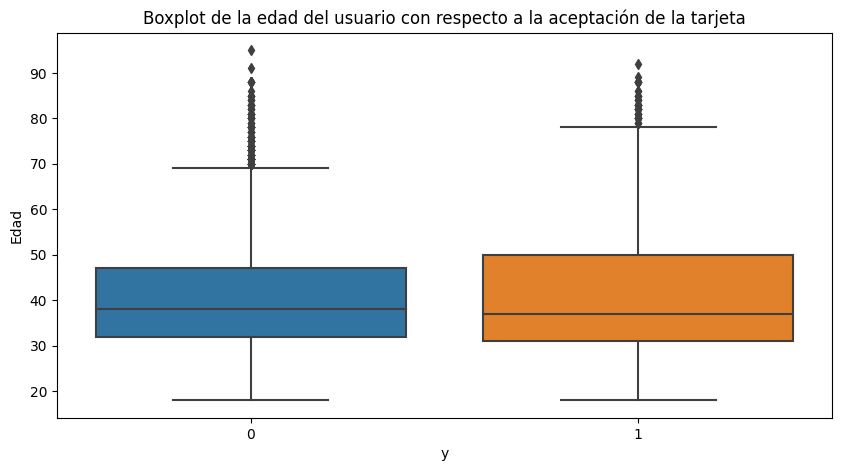

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(x='y',y='Edad',data=df)
plt.title('Boxplot de la edad del usuario con respecto a la aceptación de la tarjeta')
plt.show()

A simple vista no se logra identificar una diferencia significativa entre la edad de las personas que aceptan una tarjeta de las que no

### Prueba de hipótesis estadística

Prueba de hipótesis estadística de diferencia de medias para validar si hay diferencia estadísticamente significativa entre las edad de las personas que aceptan una tarjeta de las que no

*<center>H0: Media de edad de personas que aceptan = Media de edad de personas que rechazan<center>*
*<center>H1: Medida de edad de personas que aceptan <> Media de edad de personas que rechazan<center>*


In [22]:
age_accepted = df[df['y'] == 1]['Edad']
age_rejected = df[df['y'] == 0]['Edad']

statistic, p_value = mannwhitneyu(age_accepted, age_rejected)

print('Mann-Whitney U statistic:', statistic)
print('p-value:', p_value)

Mann-Whitney U statistic: 26288455.0
p-value: 0.39700793688977265


De acuerdo al resultado de la prueba, no es posible rechazar la hipótesis nula, por lo que no es posible concluir de que existe una diferencia estadísticamente significativa entre la media de las edades de las personas que aceptan y las que rechazan la tarjeta, esto debido a que el valor p está muy por encima del valor de significancia que es 0.05

Gráfico de densograma por edades

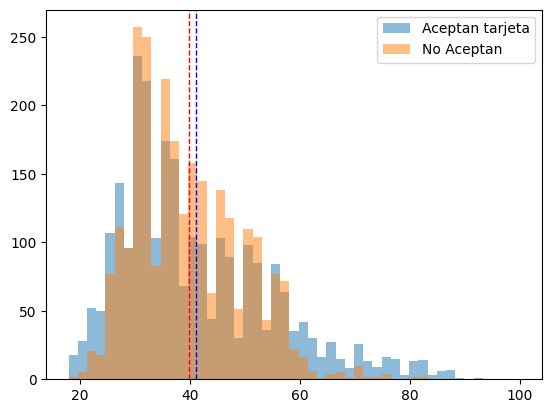

In [23]:
age_rejected = age_rejected.sample(n=2590)
bins = np.linspace(18,100)
plt.hist(age_accepted, bins, alpha=0.5, label='Aceptan tarjeta')
plt.axvline(age_accepted.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.hist(age_rejected, bins, alpha=0.5, label='No Aceptan')
plt.axvline(age_rejected.mean(), color='red', linestyle='dashed', linewidth=1)
plt.legend(loc='upper right')
plt.show()

Al graficar los densogramas de cada una de las distribuciones de edad por grupo (personas que aceptan y rechazan) tampoco se logra identificar una diferencia marcada, lo cual es una corroboración gráfica de los resultados obtenidos anteriormente

### Análisis de variables categóricas

Función para generar tabla y gráfico de frecuencias con el objetivo de identificar los resultados de cada variable que más llevan a que se acepte una tarjeta de crédito

In [24]:
def grafico_frecuencia(variable):
    result = df.groupby([variable, 'y']).size().unstack()
    result['Total'] = result.sum(axis=1)
    result['% Aceptacion'] = result[1]/result['Total']
    plt.figure(figsize=(20,5))
    sns.barplot(x=result.index,y=result['% Aceptacion'])
    for i in range(result.shape[0]):
        plt.text(x=i , y=result['% Aceptacion'][i], s=result['Total'][i], horizontalalignment='center')
    plt.xlabel(variable)
    plt.ylabel('% Aceptacion')
    plt.title('Gráfico de frecuencia de la variable '+variable+' con respecto a la aceptación de la tarjeta')
    return plt.show(), result


Función para generar un test de prueba de hipótesis estadístico de cada variable categórica con respecto a la variable objetivo empleando el estadístico Chi2

In [25]:
def test_value(variable):
    contingency_table = pd.crosstab(df[variable], df['y'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return 'p value:', p

### Análisis Estado civil

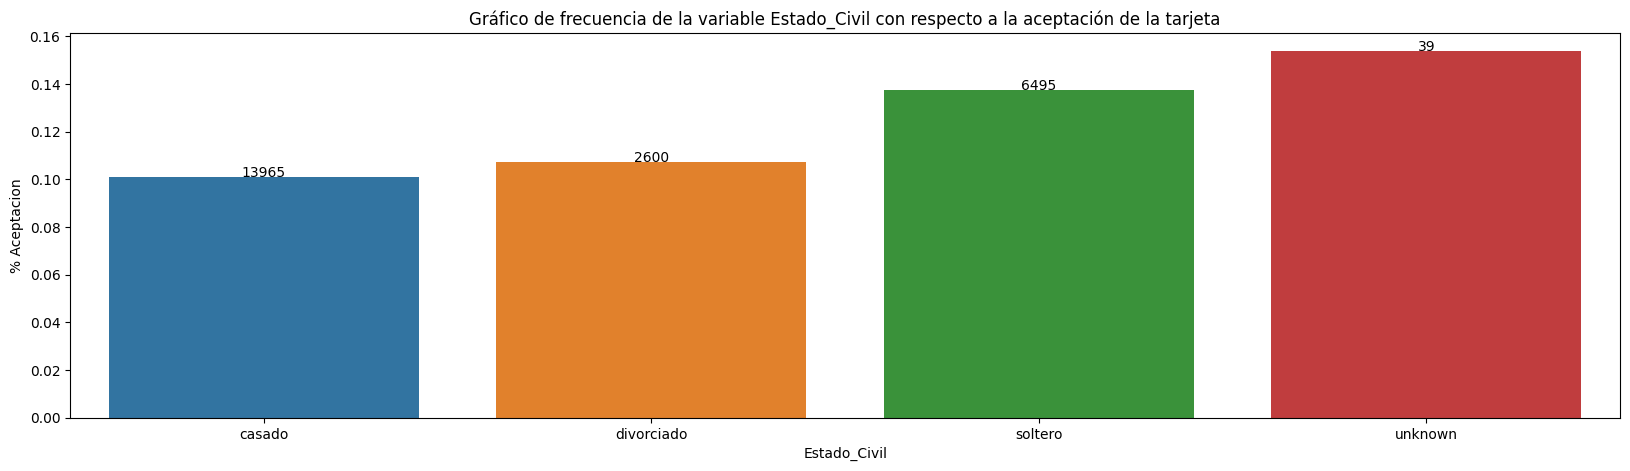

(None,
 y                 0     1  Total  % Aceptacion
 Estado_Civil                                  
 casado        12553  1412  13965      0.101110
 divorciado     2321   279   2600      0.107308
 soltero        5602   893   6495      0.137490
 unknown          33     6     39      0.153846)

In [26]:
grafico_frecuencia('Estado_Civil')

De acuerdo a los resultados anteriores, las personas solteras son las que proporcionalmente más aceptan tarjetas de crédito con casi un 14%, siendo descartado unknown debido a la poca cantidad de muestras (solo 39 registros)

*<center>H0: Estado civil de personas que aceptan = Estado civil de personas que rechazan<center>*
*<center>H1: Estado civil de personas que aceptan <> Estado civil de personas que rechazan<center>*

In [27]:
test_value('Estado_Civil')

('p value:', 5.111231284094124e-13)

De acuerdo a la prueba de hipótesis, es posible rechazar la hipótesis nula, por lo cual es posible concluir de que existe una diferencia estadísticamente significativa entre el estado civil de las personas que aceptan una tarjeta de crédito con respecto a las que la rechazan, lo cual es congruente con la gráfica de frecuencias donde se evidencia que las personas solteras son más propénsas a aceptar las tarjetas de crédito

### Educación

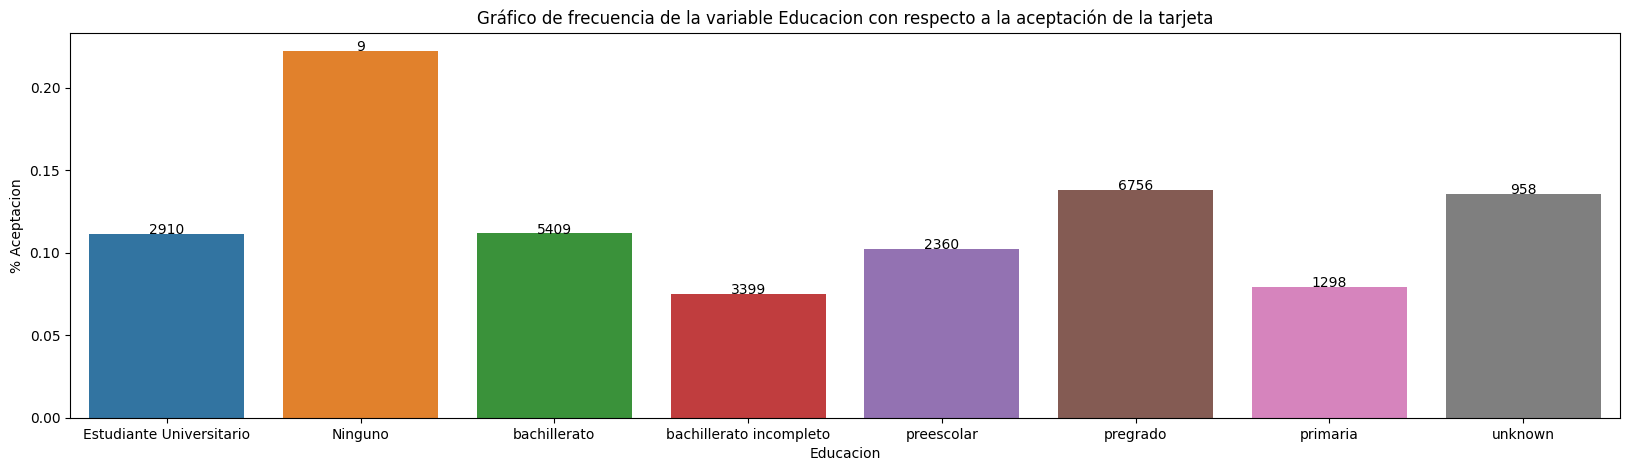

(None,
 y                            0    1  Total  % Aceptacion
 Educacion                                               
 Estudiante Universitario  2586  324   2910      0.111340
 Ninguno                      7    2      9      0.222222
 bachillerato              4805  604   5409      0.111666
 bachillerato incompleto   3144  255   3399      0.075022
 preescolar                2119  241   2360      0.102119
 pregrado                  5825  931   6756      0.137803
 primaria                  1195  103   1298      0.079353
 unknown                    828  130    958      0.135699)

In [28]:
grafico_frecuencia('Educacion')

De acuerdo a los resultados anteriores, las personas con pregrado son las que proporcionalmente más aceptan tarjetas de crédito con casi un 14%, siendo descartado unknown debido a que se desconoce el valor y Ninguno debido a la poca cantidad de muestras

*<center>H0: Educación de personas que aceptan = Educación de personas que rechazan<center>* 
*<center>H1: Educación de personas que aceptan <> Educación de personas que rechazan<center>*

In [29]:
test_value('Educacion')

('p value:', 1.0186173996119251e-21)

De acuerdo a la prueba de hipótesis, es posible rechazar la hipótesis nula, por lo cual es posible concluir de que existe una diferencia estadísticamente significativa entre el nivel de eduación de las personas que aceptan una tarjeta de crédito con respecto a las que la rechazan, lo cual es congruente con la gráfica de frecuencias donde se evidencia que las personas con pregrado y bachillerato concluido son más propensas a aceptar tarjetas de crédito con respecto a los demás niveles de educación

### Tipo de trabajo

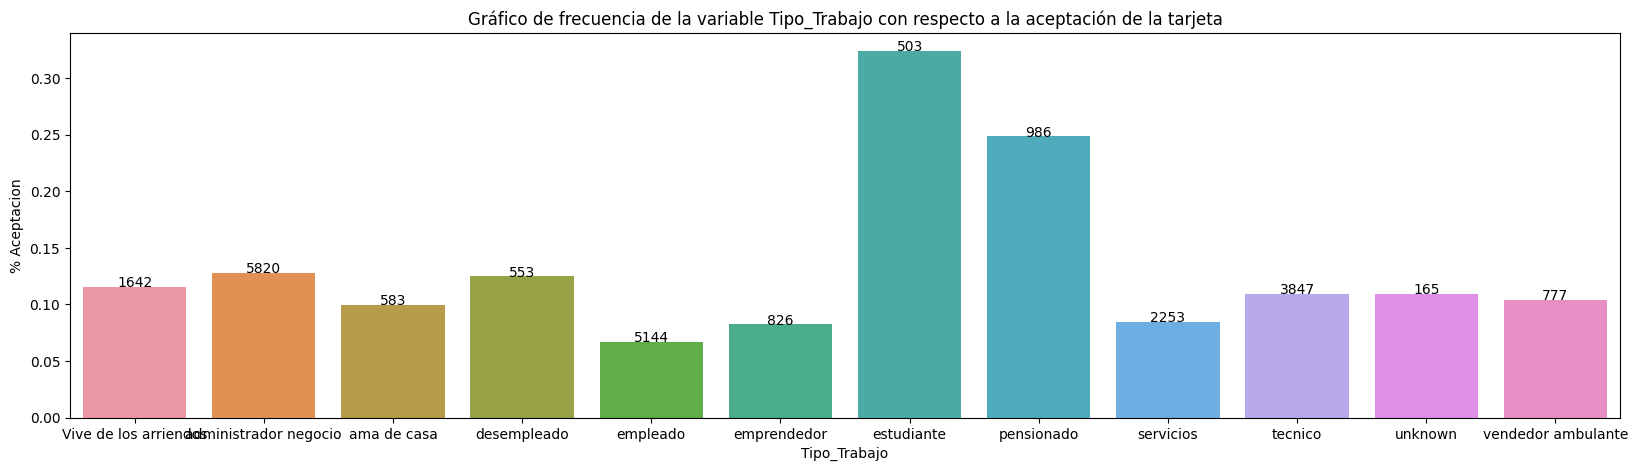

(None,
 y                         0    1  Total  % Aceptacion
 Tipo_Trabajo                                         
 Vive de los arriendos  1452  190   1642      0.115713
 administrador negocio  5077  743   5820      0.127663
 ama de casa             525   58    583      0.099485
 desempleado             484   69    553      0.124774
 empleado               4801  343   5144      0.066680
 emprendedor             758   68    826      0.082324
 estudiante              340  163    503      0.324056
 pensionado              741  245    986      0.248479
 servicios              2062  191   2253      0.084776
 tecnico                3426  421   3847      0.109436
 unknown                 147   18    165      0.109091
 vendedor ambulante      696   81    777      0.104247)

In [30]:
grafico_frecuencia('Tipo_Trabajo')

De acuerdo a los resultados anteriores, los estudiantes y pensionados son el grupo de población que proporcionalmente más aceptan tarjetas de crédito, sin embargo es importante mencionar al grupo de administradores de negocio, los cuales aunque tienen un porcentaje de aceptación menor, es interesante debido a la gran cantidad de registros que tiene, siendo el grupo con mayor cantidad de muestras, lo que lo haría el grupo con más aceptaciones totales

*<center>H0: Tipo de trabajo de personas que aceptan = Tipo de trabajo de personas que rechazan<center>*
*<center>H1: Tipo de trabajo de personas que aceptan <> Tipo de trabajo de personas que rechazan<center>*

In [31]:
test_value('Tipo_Trabajo')

('p value:', 8.096660190054259e-113)

De acuerdo a la prueba de hipótesis, es posible rechazar la hipótesis nula, por lo cual es posible concluir de que existe una diferencia estadísticamente significativa entre el tipo de trabajo u ocupación de las personas con respecto a la probabilidad de que acepten o no una tarjeta de crédito

### Vivienda

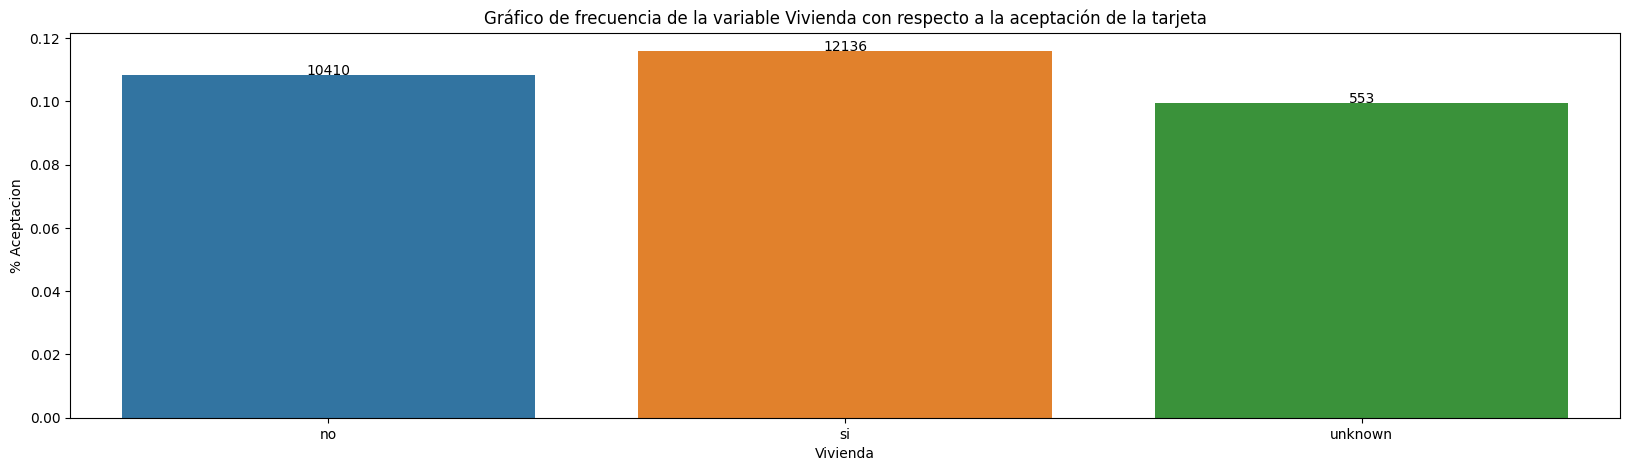

(None,
 y             0     1  Total  % Aceptacion
 Vivienda                                  
 no         9282  1128  10410      0.108357
 si        10729  1407  12136      0.115936
 unknown     498    55    553      0.099458)

In [32]:
grafico_frecuencia('Vivienda')

De acuerdo a los resultados anteriores, las personas con vivienda son más propensas a aceptar tarjetas de crédito

*<center>H0: Vivienda de personas que aceptan = Vivienda de personas que rechazan<center>*
*<center>H1: Vivienda de personas que aceptan <> Vivienda de personas que rechazan<center>*

In [33]:
test_value('Vivienda')

('p value:', 0.12579231301643312)

De acuerdo a la prueba de hipótesis, no es posible rechazar la hipótesis nula, por lo cual no es posible concluir de que existe una diferencia estadísticamente significativa entre las personas que tienen casas y las que no con respecto a la probabilidad de que acepten o no una tarjeta de crédito

## Ingeniería de carcaterísticas

### Selección variables más relevantes

Se usará el método SelectKBest para identificar aquellas variables más relevantes para el modelo de acuerdo a su nivel de significancia con respecto a la variable objetivo, este método tiene en cuenta la varianza explicada de cada una de las características

Se debe generar el conjunto de las variables independientes y la variable dependiente

In [34]:
x = df.drop(['y'],axis=1)
y = df['y']

Se realiza el one hot encoding

In [35]:
x = pd.get_dummies(x, drop_first=True)

Se aplica el método de SelectKBest explicado anteriormente

In [36]:
selection = SelectKBest(score_func=f_classif,k='all')
selection.fit(x, y)
selection

SelectKBest(k='all')

Se grafican los resultados obtenidos para identificar las variables más relevantes

Feature 0: 29.167575
Feature 1: 110.073311
Feature 2: 2634.597806
Feature 3: 1270.099412
Feature 4: 2251.847910
Feature 5: 18.879932
Feature 6: 0.959912
Feature 7: 0.910347
Feature 8: 138.102639
Feature 9: 7.644027
Feature 10: 234.315485
Feature 11: 193.948132
Feature 12: 18.771992
Feature 13: 0.335506
Feature 14: 0.015377
Feature 15: 0.501341
Feature 16: 0.683207
Feature 17: 58.534173
Feature 18: 0.682977
Feature 19: 1.096178
Feature 20: 0.015032
Feature 21: 55.241004
Feature 22: 2.644332
Feature 23: 63.408458
Feature 24: 14.846126
Feature 25: 5.579714
Feature 26: 0.252575
Feature 27: 260.372879
Feature 28: 3.728740
Feature 29: 0.913324
Feature 30: 0.045160
Feature 31: 0.913324
Feature 32: 469.058741
Feature 33: 1.480142
Feature 34: 125.772312
Feature 35: 32.680965
Feature 36: 1.185812
Feature 37: 506.347174
Feature 38: 252.391412
Feature 39: 2.425770
Feature 40: 445.166258
Feature 41: 399.731533
Feature 42: 13.647767
Feature 43: 4.462844
Feature 44: 1.801248
Feature 45: 1.854085
Feat

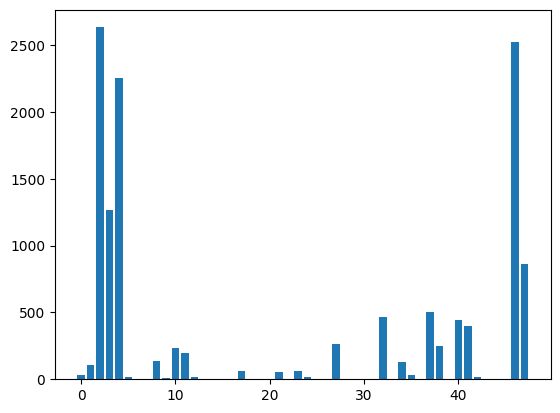

Text(0, 0.5, 'Variables')

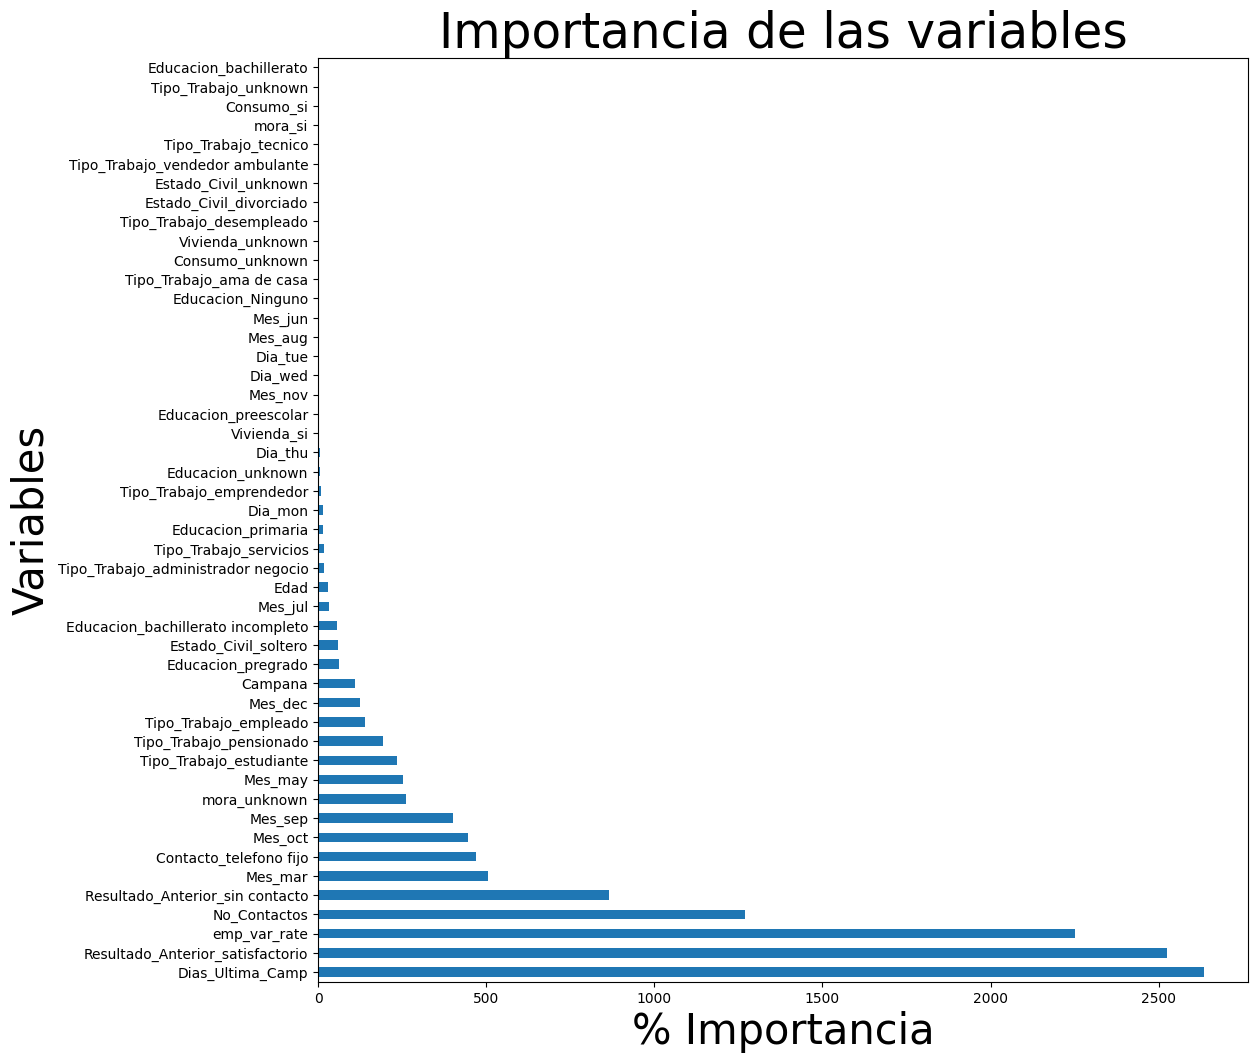

In [37]:
for i in range(len(selection.scores_)):
	print('Feature %d: %f' % (i, selection.scores_[i]))
plt.bar([i for i in range(len(selection.scores_))], selection.scores_)
plt.show()

plt.figure(figsize=(12,12),facecolor='w', edgecolor='k',num=1)
feat_importances = pd.Series(selection.scores_, index= x.columns)
feat_importances.nlargest(60).plot(kind='barh')
parameters = {'axes.labelsize': 50,
          'axes.titlesize':50}
plt.rcParams.update(parameters)
plt.title('Importancia de las variables',fontsize=35)
plt.xlabel('% Importancia', fontsize=30)
plt.ylabel('Variables', fontsize=30)

A continuación se seleccionan las variables más relevantes identificadas con el método anterior para finalmente ser usadas en el paso de modelado

In [38]:
variables_depuradas = ['Edad', 'Tipo_Trabajo', 'Estado_Civil', 'Educacion', 'Contacto', 'Mes', 'Campana',
       'Dias_Ultima_Camp', 'No_Contactos', 'Resultado_Anterior',
       'emp_var_rate', 'y']

Se guardan las variables en un .pkl para ser usadas posteriormente

In [63]:
variables_seleccionadas = ['Edad', 'Tipo_Trabajo', 'Estado_Civil', 'Educacion', 'Contacto', 'Mes', 'Campana',
       'Dias_Ultima_Camp', 'No_Contactos', 'Resultado_Anterior',
       'emp_var_rate']
joblib.dump(variables_seleccionadas, 'variables_seleccionadas.pkl')

['variables_seleccionadas.pkl']

In [39]:
df = df[variables_depuradas]

## Modelos de Machine Learning

División de datos en X y Y

In [41]:
X = df.drop(['y'],axis=1)
Y = df['y']

Aplicación de técnica de One hot encoding para llevar las variables categóricas a numéricas

In [42]:
columns_to_fit = [variable for variable in X.columns if X[variable].dtype == 'object']
enc = OneHotEncoder(sparse=False, drop='if_binary').fit(df.loc[:, columns_to_fit])

c:\AI\Banco\banco\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Se guarda el objeto encoder para aplicarse en producción

In [43]:
joblib.dump(enc, 'encoder.pkl')

['encoder.pkl']

Se generan nuevamente el conjunto de X y Y ya con las variables resultantes del One hot encoding

In [45]:
column_names = enc.get_feature_names_out(columns_to_fit)
encoded_variables = pd.DataFrame(enc.transform(df.loc[:, columns_to_fit]), columns=column_names)
df = df.drop(columns_to_fit, axis=1)
df = pd.concat([df, encoded_variables], axis=1)

In [46]:
X = df.drop(['y'],axis=1)
Y = df['y']

Se estandarizan las variables utilizando la técnica de Min Max Scaler, la cual lleva todo a rangos entre 0 y 1 

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)

Se guarda el objeto scaler para utilizarse en producción

In [48]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [49]:
norm = scaler.transform(X)
x_norm = pd.DataFrame(norm,index=df.index,columns=X.columns)

Se genera el conjunto de datos de entrenamiento y testeo, empleando un 20% para testeo

In [85]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.20,random_state=42, stratify=y)

### Gráfica de valores a clasificar

Se utilizará la técnica de Principal Component Analysis para extraer las dos componentes principales y así poder graficar los datos que se desean clasificar, esto con el fin de generar una visualización del problema a resolver

In [51]:
pca = PCA(n_components=2)
pca.fit(X_test)
X_pca = pca.transform(X_test)

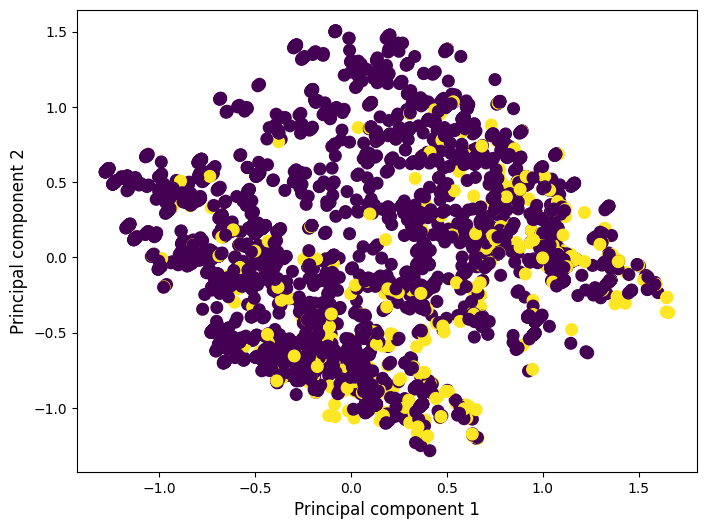

In [52]:
plt.figure(figsize=(8,6),facecolor='w', edgecolor='k',num=1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, s=70, cmap='viridis')
plt.xlabel('Principal component 1', fontsize=12)
plt.ylabel('Principal component 2', fontsize=12)
plt.show()

El objetivo es encontrar el mejor modelo de Machine Learning que logre idenfiticar el patrón de los datos de aceptación de tarjeta y rechazo de tarjeta (valores morados y amarillos)

### Entrenamiento de los modelos

Se escogieron 6 modelos incialmente para entrenarse, de estos 6 se identificarán los 3 mejores modelos de acuerdo a las métricas de Accuracy y F1 Score con los cuales se tunearán para encontrar los hiperparámetros óptimos, y finalmente obtener el mejor modelo que sea posteriormente desplegado en unA API

La siguiente función entrena cada uno de los 6 modelos pasados por parámetro, es importante anotar que para cada entrenamiento se realiza un resample empleando la técnica de SMOTE, la cual hace un balanceo de datos generándo un sub sampling de la muestra dominante, que para el caso es la de rechazo de tarjetas

In [53]:
def train_model(model):
    dist_models = {
        'LogisticRegression': LogisticRegression(),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'DecisionTreeClassifier': DecisionTreeClassifier(),
        'RandomForestClassifier': RandomForestClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'AdaBoostClassifier': AdaBoostClassifier()
    }
    model = dist_models[model]
    resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
    pipeline=Pipeline(steps=[('r', resample), ('m', model)])
    pipeline.fit(X_train,y_train,)
    pipe_log_train = pipeline.predict(X_train)
    pipe_log_test = pipeline.predict(X_test)
    report = classification_report(y_train,pipe_log_train,output_dict=True)
    report_pipe = pd.DataFrame(report).transpose()
    return report

Regresión Logística

In [54]:
train_model('LogisticRegression')

c:\AI\Banco\banco\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'0': {'precision': 0.9519982303495059,
  'recall': 0.7867763558805606,
  'f1-score': 0.8615374349392766,
  'support': 16410},
 '1': {'precision': 0.2883872279845434,
  'recall': 0.6853552440792653,
  'f1-score': 0.40595476667620956,
  'support': 2069},
 'accuracy': 0.7754207478759673,
 'macro avg': {'precision': 0.6201927291670246,
  'recall': 0.736065799979913,
  'f1-score': 0.6337461008077431,
  'support': 18479},
 'weighted avg': {'precision': 0.8776970688205753,
  'recall': 0.7754207478759673,
  'f1-score': 0.8105281519349861,
  'support': 18479}}

K vecinos más cercanos

In [55]:
train_model('KNeighborsClassifier')

{'0': {'precision': 0.9766457348479504,
  'recall': 0.843510054844607,
  'f1-score': 0.9052087761174509,
  'support': 16410},
 '1': {'precision': 0.4036228518346493,
  'recall': 0.8400193330111165,
  'f1-score': 0.5452549019607844,
  'support': 2069},
 'accuracy': 0.8431192164078143,
 'macro avg': {'precision': 0.6901342933412998,
  'recall': 0.8417646939278618,
  'f1-score': 0.7252318390391177,
  'support': 18479},
 'weighted avg': {'precision': 0.9124872660479872,
  'recall': 0.8431192164078143,
  'f1-score': 0.8649065646541605,
  'support': 18479}}

Árbol de decisión

In [56]:
train_model('DecisionTreeClassifier')

{'0': {'precision': 0.979015481373972,
  'recall': 0.9865326020719074,
  'f1-score': 0.9827596673344261,
  'support': 16410},
 '1': {'precision': 0.8862583633556356,
  'recall': 0.8322861285645239,
  'f1-score': 0.8584247258225324,
  'support': 2069},
 'accuracy': 0.9692624059743492,
 'macro avg': {'precision': 0.9326369223648038,
  'recall': 0.9094093653182156,
  'f1-score': 0.9205921965784792,
  'support': 18479},
 'weighted avg': {'precision': 0.9686299368542501,
  'recall': 0.9692624059743492,
  'f1-score': 0.9688385139176768,
  'support': 18479}}

Bosques aleatorios

In [57]:
train_model('RandomForestClassifier')

{'0': {'precision': 0.9839670741446035,
  'recall': 0.9761121267519804,
  'f1-score': 0.9800238612377251,
  'support': 16410},
 '1': {'precision': 0.8218181818181818,
  'recall': 0.8738521024649589,
  'f1-score': 0.8470367767627078,
  'support': 2069},
 'accuracy': 0.9646625899669895,
 'macro avg': {'precision': 0.9028926279813927,
  'recall': 0.9249821146084697,
  'f1-score': 0.9135303190002164,
  'support': 18479},
 'weighted avg': {'precision': 0.9658120842521112,
  'recall': 0.9646625899669895,
  'f1-score': 0.9651339712123552,
  'support': 18479}}

Gradient Boosting

In [58]:
train_model('GradientBoostingClassifier')

{'0': {'precision': 0.942208985488879,
  'recall': 0.9060938452163315,
  'f1-score': 0.9237985772420862,
  'support': 16410},
 '1': {'precision': 0.42883617494440324,
  'recall': 0.5592073465442242,
  'f1-score': 0.4854205999580449,
  'support': 2069},
 'accuracy': 0.8672547215758428,
 'macro avg': {'precision': 0.6855225802166411,
  'recall': 0.7326505958802778,
  'f1-score': 0.7046095886000656,
  'support': 18479},
 'weighted avg': {'precision': 0.8847292330663172,
  'recall': 0.8672547215758428,
  'f1-score': 0.8747156163134278,
  'support': 18479}}

Ada Boosting

In [59]:
train_model('AdaBoostClassifier')

{'0': {'precision': 0.9411502452073116,
  'recall': 0.9004875076173066,
  'f1-score': 0.9203699666780853,
  'support': 16410},
 '1': {'precision': 0.41216702663786897,
  'recall': 0.5534074432092798,
  'f1-score': 0.4724571900144419,
  'support': 2069},
 'accuracy': 0.8616267114021321,
 'macro avg': {'precision': 0.6766586359225903,
  'recall': 0.7269474754132932,
  'f1-score': 0.6964135783462636,
  'support': 18479},
 'weighted avg': {'precision': 0.8819226744935188,
  'recall': 0.8616267114021321,
  'f1-score': 0.8702194425741253,
  'support': 18479}}

Los tres mejores modelos, de acuerdo a sus resultados de Accuracy y F1_Score, fueron: Árbol de decisión, Bosques aleatorios, y Gradient Boosting

### Tuneo de Hiperparámetros

Para cada uno de estos tres modelos se realizará un tuneo de hiperparámetros con el fin de entrenar el modelo con los hiperámetros óptimos

Árbol de decisión

In [86]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
model = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5, n_jobs=-1)   
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
pipeline_dt=Pipeline(steps=[('r', resample), ('m', model)])
pipeline_dt.fit(X_train,y_train)
pipe_dt_train = pipeline_dt.predict(X_train)
pipe_dt_test = pipeline_dt.predict(X_test)
report = classification_report(y_train,pipe_dt_train,output_dict=True)
report_dt_pipe = pd.DataFrame(report).transpose()
report_dt_pipe

,precision,recall,f1-score,support
0,0.978551,0.984336,0.981435,16407.000000
1,0.869873,0.829151,0.849024,2072.000000
accuracy,0.966935,0.966935,0.966935,0.966935
macro avg,0.924212,0.906743,0.915229,18479.000000
weighted avg,0.966365,0.966935,0.966588,18479.000000


Bosques aleatorios

In [50]:
rf_para = {'n_estimators':[10,20,30,40,50,60,100], 'criterion':['gini','entropy'],
           'max_depth':[4,5,6,7,8],
           'bootstrap':[True,False], 'min_samples_split':[2,3,4,5,6],
           'min_samples_leaf':[1,2,3,4,5]}
model = GridSearchCV(RandomForestClassifier(), rf_para, cv=3, n_jobs=-1)
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
pipeline_rf=Pipeline(steps=[('r', resample), ('m', model)])
pipeline_rf.fit(X_train,y_train)
pipe_rf_train = pipeline_rf.predict(X_train)
pipe_rf_test = pipeline_rf.predict(X_test)
report = classification_report(y_train,pipe_rf_train,output_dict=True)
report_rf_pipe = pd.DataFrame(report).transpose()
report_rf_pipe

,precision,recall,f1-score,support
0,0.95,0.83,0.89,16410.00
1,0.33,0.66,0.44,2069.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.64,0.75,0.66,18479.00
weighted avg,0.88,0.81,0.84,18479.00


Gradient Boosting

In [51]:
gb_para = {'learning_rate':[0.1,0.2,0.3,0.4,0.5],
              'n_estimators':[10,20,30,40,50,60,100],'criterion':['friedman_mse','mse','mae'],
                'max_depth':[4,5,6,7,8]}
model = GridSearchCV(GradientBoostingClassifier(), gb_para, cv=3, n_jobs=-1)
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
pipeline_gb=Pipeline(steps=[('r', resample), ('m', model)])
pipeline_gb.fit(X_train,y_train)
pipe_gb_train = pipeline_gb.predict(X_train)
pipe_gb_test = pipeline_gb.predict(X_test)
report = classification_report(y_train,pipe_gb_train,output_dict=True)
report_gb_pipe = pd.DataFrame(report).transpose()
report_gb_pipe

,precision,recall,f1-score,support
0,0.95,0.98,0.97,16410.00
1,0.82,0.61,0.70,2069.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.89,0.80,0.84,18479.00
weighted avg,0.94,0.94,0.94,18479.00


### Selección del mejor modelo

De acuerdo a las métricas obtenidas, finalmente se selecciona el modelo de Árboles de decisión ya que el F1-Score y Accuracy son bastantes superiores a los otros dos, inclusive mostrando mucho mejor rendimiento en el macro avg para ambas métricas, lo que demuestra una mejor capacidad de generalización y balanceo

Matríz de confusión del modelo de Árbol de decisión

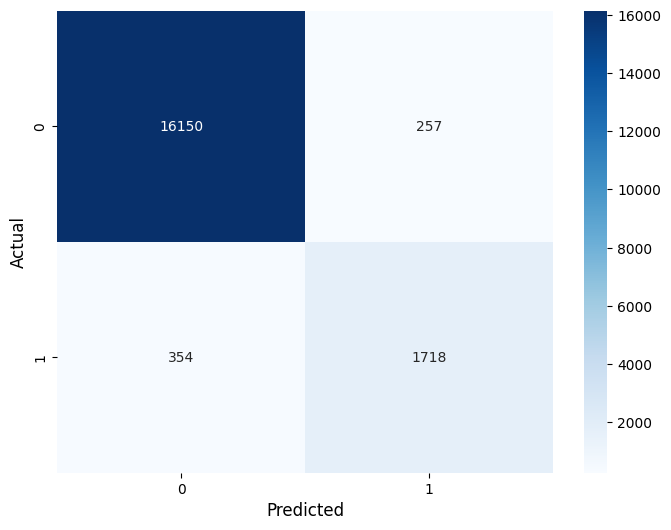

In [87]:
cm = confusion_matrix(y_train, pipe_dt_train)
plt.figure(figsize=(8,6),facecolor='w', edgecolor='k',num=1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()   

La matriz da evidencia de que apesar de una precisión por encima del 90%, el modelo aún genera muchos registros mal clasificados, por ejemplo 354 clientes que el mmodelo predice que no aceptarán la tarjeta de crédito cuando realmente si la aceptaron, y 257 que el modelo predice que la aceptarán cuando realmente no lo hicieron. El rendimiento del modelo de podría mejorar aún más con mayor cantidad de registros, nuevas variables como ingresos económicos, estrato, entre otras variables socio demográficas y económicas, y entrenando modelos más robustos, por ejemplo un ensamble de distintos modelos empleando la técnica de VottingClassifier

Se guarda el modelo entrando para su operacionalización

In [59]:
joblib.dump(pipeline_dt, 'model_classification.pkl')

['model_classification.pkl']

A continuación se muestra el rendimmiento del modelo de forma gráfica, generando su capacidad de clasificación al problema planteado de clasificar los clientes que aceptan o rechazan una tarjeta

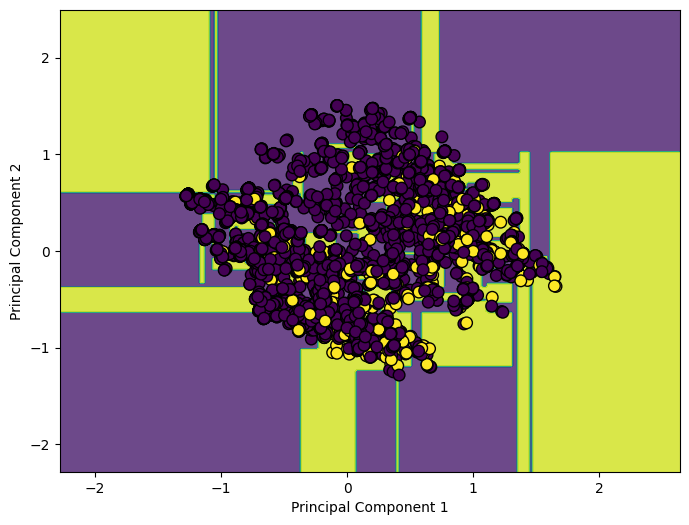

In [60]:
pipeline_dt.fit(X_pca,y_test)
h = .02 
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = pipeline_dt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=.8, cmap=plt.cm.viridis)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c= y_test, s=70, cmap=plt.cm.viridis, edgecolor='k')
plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.show()

# Testeo

En esta parte se hará el testeo del modelo a partir de los datos de test

Se llaman nuevamente los objetos guardados: modelo, scaler, encoder, variables

In [64]:
model = joblib.load('deployment/files/model_classification.pkl')
scaler = joblib.load('deployment/files/scaler.pkl')
encoder = joblib.load('deployment/files/encoder.pkl')
variables = joblib.load('deployment/files/variables_seleccionadas.pkl')

In [66]:
categorical = encoder.feature_names_in_

Se leen los datos de test para hacer la respectiva predicción

In [74]:
data = pd.read_csv('../data/insumo/test.csv')

La siguiente función hace la transformación de las variables empleando la selección de variables, los reemplazos de valores, el one hot encoding, y la estandarización

In [75]:
def transform(df):
    df = df[variables]
    df['Estado_Civil'] = ["soltero" if x == 'single' else x for x in df['Estado_Civil']]
    df['Estado_Civil'] = ["divorciado" if x == 'divorced' else x for x in df['Estado_Civil']]
    encoded_df = pd.DataFrame(
        encoder.transform(df[categorical]),
        columns=encoder.get_feature_names_out(categorical)
    )
    df = pd.concat([df.drop(categorical, axis=1), encoded_df], axis=1)

    scaled_df = pd.DataFrame(
        scaler.transform(df),
        columns=df.columns
    )
    return scaled_df

In [76]:
df_test = transform(data)

Se crea una nueva variable llamada Predicción en donde se guardan los resultados de las estimaciones realizadas por el modelo

In [77]:
data['Prediccion'] = model.predict(df_test)

Se crea una nueva variable llamada Probabilidad en donde se guardan las probabilidades de cada predicción que realiza el modelo

In [78]:
data['Probabilidad'] = model.predict_proba(df_test).max(axis=1)

Finalmente, se guarda el Dataframe con las predicciones en la carpeta de salida como formato .csv

In [81]:
data.to_csv('../data/salida/test_prediccion.csv', index=False)